# About the Data

* The data was taken from 
the csv file complaints.csv


* The complaints are for the products:<br>

  1. 'Bank account or service'
  2. 'Checking or savings account'
  3. 'Consumer Loan'
  4. 'Credit card or prepaid card'
  5. 'Credit reporting, credit repair services, or other personal consumer reports' 
  6. 'Debt collection'
  7. Money transfer/s, virtual currency, or money service'
  8. 'Mortgage'
  9. 'Payday loan, title loan, or personal loan'
  10. 'Student loan'
  11. 'Vehicle loan or lease'


* The data cleaning and stopwords removal was done using the spacy library

* The sample data has at most 10 percent 'MASK' words. 



# Fine Tuning DistilBERT model for text classification

* The model was trained on 3 epochs and the learning rate was set at 2e-5 and batch size 16

* Total training time taken across all epochs [Validation and model saving time included]:  1:27:45 (h:mm:ss)

* Data Split:<br>
      -Training data: 18445 (72 percent)
      -Validation data: 4612 (18 percent)
      -Test Data : 2562 (10 percent)

* Macro-averaged f1-score<br>
      -Training data: 0.66
      -Validation data: 0.64

  
* Fine-tuning was done on the sample data of size 25619 entries
   


## Next Steps

* Calculate Metrics on the test Data Set 

* Use Sample Data that has fewer 'MASK' words percentage. DistilBERT performs Masked language modeling and  when taking a sentence, the model randomly masks 15% of the words in the input and predicts the masked words. Since the Sample data has at most 10 percent 'MASK' words there is a possibility that the model might be predicting 25 percent masked words. More masking would provide insufficient context to learn good representations. 

* Fine-tune DistilBERT on a dataset of size 50,000




##Google Drive access

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [2]:
# write the appropriate paths to retrieve the data and store results 
sample_data_path_clean = '/content/drive/MyDrive/SAMPLE_DOC_10_PER_MASK.csv'
checkpoint_path = "/content/checkpoint/current_checkpoint.pt"
best_model_path = "/content/best_model/best_model.pt"
used_test_data_path = "/content/best_model/Test_data_DistilBERT.csv"
encoded_test_data_path = "/content/best_model/ENCODED_Test_data_DistilBERT.csv"
label2id_df_path = "/content/best_model/label2id_df.csv"

## Set-up environment

Install the libraries HuggingFace Transformers and Datasets

In [3]:
#Install HuggingFace tranformer and datasets libraries  
!pip install -q transformers datasets 

##Import the Libraries

In [4]:
import torch
import collections 

In [5]:
#Check if GPU is available

device = "cuda:0" if torch.cuda.is_available() else "cpu"
print(device, "is available")

cuda:0 is available


# Loading the dataset

In [6]:
#Load the data
import pandas as pd

sample_df = pd.read_csv(sample_data_path_clean, dtype={"Consumer complaint narrative": "string", "Consumer consent provided?": "string", "Timely response?":"string"})
sample_df.head()


,consumer_complaint_narrative,product,split_words_whitespaces,number_of_words,number_of_charachters,charachters_by_words,number_of_unique_words,potenial_mask_words,number_of_potenial_mask_words,potenial_mask_words_BY_words,spacy_doc,Masked_text,Change_text,number_of_<MASK>,<MASK>_BY_WORDS
0,Have two issues with my wellsfargo accounts : ...,Bank account or service,"['issues', 'wellsfargo', 'accounts', '1.', 'ba...",105,763,7,66,"['XXXX', 'XXXX', 'XXXX', 'XXXX', 'XXXX.', 'XXXX']",6,0.025424,Have two issues with my wellsfargo accounts : ...,Have two issues with my wellsfargo accounts : ...,issues wellsfargo accounts 1. bank continue c...,6,0.057143
1,"On or about XXXX XXXX, 2016, I logged into my ...",Bank account or service,"['<MASK>', '2016', 'logged', 'Flagstar', 'Bank...",140,1049,7,80,"['XXXX', 'XXXX,', 'XXXX', 'XXXX,', 'XXXX', 'XX...",8,0.026316,"On or about XXXX XXXX, 2016, I logged into my ...","On or about <MASK> , 2016, I logged into my F...",<MASK> 2016 logged Flagstar Bank checking acc...,4,0.028571
2,I have notice some charges to my checking acco...,Bank account or service,"['notice', 'charges', 'checking', 'account.', ...",133,950,7,86,"['XXXX', 'XXXX,', 'XXXX', 'XXXX.', 'XXXX', 'XX...",12,0.037618,I have notice some charges to my checking acco...,I have notice some charges to my checking acco...,notice charges checking account. merchant cha...,9,0.067669
3,""" PayPal Credit '' gave me a credit line of {$...",Bank account or service,"['PayPal', 'Credit', 'gave', 'credit', 'line',...",116,840,7,91,['XXXX'],1,0.003846,""" PayPal Credit '' gave me a credit line of {$...",""" PayPal Credit '' gave me a credit line of {$...",PayPal Credit gave credit line $ 1200.00 onli...,1,0.008621
4,I opened a checking account with Simple Bank (...,Bank account or service,"['opened', 'checking', 'account', 'Simple', 'B...",196,1417,7,122,"['XXXX', 'XXXX,', 'XXXX', 'XXXX,', 'XXXX/XXXX/...",20,0.042194,I opened a checking account with Simple Bank (...,I opened a checking account with Simple Bank (...,opened checking account Simple Bank BBVA Comp...,13,0.066327


In [7]:
data = sample_df.copy()
data.rename(columns = {'Change_text':'Text', 'product':'Topic'}, inplace = True)
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 26826 entries, 0 to 26825
Data columns (total 15 columns):
 #   Column                         Non-Null Count  Dtype  
---  ------                         --------------  -----  
 0   consumer_complaint_narrative   26826 non-null  object 
 1   Topic                          26826 non-null  object 
 2   split_words_whitespaces        26826 non-null  object 
 3   number_of_words                26826 non-null  int64  
 4   number_of_charachters          26826 non-null  int64  
 5   charachters_by_words           26826 non-null  int64  
 6   number_of_unique_words         26826 non-null  int64  
 7   potenial_mask_words            26826 non-null  object 
 8   number_of_potenial_mask_words  26826 non-null  int64  
 9   potenial_mask_words_BY_words   26826 non-null  float64
 10  spacy_doc                      26826 non-null  object 
 11  Masked_text                    26826 non-null  object 
 12  Text                           26826 non-null 

In [8]:
data['Topic'].value_counts()

Credit reporting, credit repair services, or other personal consumer reports    8918
Debt collection                                                                 5319
Credit card or prepaid card                                                     3459
Mortgage                                                                        3362
Student loan                                                                    1502
Checking or savings account                                                     1324
Bank account or service                                                          898
Money transfer/s, virtual currency, or money service                             546
Consumer Loan                                                                    508
Payday loan, title loan, or personal loan                                        500
Vehicle loan or lease                                                            490
Name: Topic, dtype: int64

In [9]:
#Drop duplicate 'Text'
data = data.drop_duplicates(subset=['Text']).reset_index(drop= True)
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 25619 entries, 0 to 25618
Data columns (total 15 columns):
 #   Column                         Non-Null Count  Dtype  
---  ------                         --------------  -----  
 0   consumer_complaint_narrative   25619 non-null  object 
 1   Topic                          25619 non-null  object 
 2   split_words_whitespaces        25619 non-null  object 
 3   number_of_words                25619 non-null  int64  
 4   number_of_charachters          25619 non-null  int64  
 5   charachters_by_words           25619 non-null  int64  
 6   number_of_unique_words         25619 non-null  int64  
 7   potenial_mask_words            25619 non-null  object 
 8   number_of_potenial_mask_words  25619 non-null  int64  
 9   potenial_mask_words_BY_words   25619 non-null  float64
 10  spacy_doc                      25619 non-null  object 
 11  Masked_text                    25619 non-null  object 
 12  Text                           25619 non-null 

In [10]:
data = data.loc[:,['Text','Topic']]
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 25619 entries, 0 to 25618
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   Text    25619 non-null  object
 1   Topic   25619 non-null  object
dtypes: object(2)
memory usage: 400.4+ KB


In [57]:
data.tail()

,Text,Topic
25614,reviewing current credit report bureau came a...,Vehicle loan or lease
25615,turned leased vehicle told owed. Shortly bega...,Vehicle loan or lease
25616,particular account situation lately filing cr...,Vehicle loan or lease
25617,<MASK> <MASK> <MASK> purchased vehicle financ...,Vehicle loan or lease
25618,Exeter allow payments loan. want repossess con...,Vehicle loan or lease


In [11]:
#Convert the Data into HuggingFace Dataset
from datasets import Dataset
dataset = Dataset.from_pandas(data)
dataset

Dataset({
    features: ['Text', 'Topic'],
    num_rows: 25619
})

The dataset has to be split into training, validation and test set. Let's check the first example of the dataset:



In [12]:
example = dataset[0]
example

{'Text': ' issues wellsfargo accounts 1. bank continue charge overdraft fees online transfers balance <MASK> charged <MASK> fees the last 4 weeks.  2. bank <MASK> double paid employees payroll process direct deposits voided payroll. retrieve funds employees double paid inert debited business account drew account <MASK> records called directed pay employees manually voided payroll. bank refuses accountability.  3. payroll issue bank started taking money rent account cover payroll overdraft created. removed money rent account bounced rent checks business cause rent account overdrawn <MASK>. bank taking accountability feels like want business accounts. bank business financial jeopardy. charged business accounts close <MASK> incorrect overdraft fees the last 8 weeks.',
 'Topic': 'Bank account or service'}

The dataset consists of text, with one or more topic labels. Let's check the frequency count of the labels 

In [13]:
#Define the function to check the frequency count of elements in the list
def frequency_count(mylist):
  frequency = collections.Counter(mylist)
  [print(key,':',value) for key, value in frequency.items()]

In [14]:
print("The Frequency of Topics in the Dataset : \n")
frequency_count(dataset['Topic'])

The Frequency of Topics in the Dataset : 

Bank account or service : 897
Checking or savings account : 1324
Consumer Loan : 507
Credit card or prepaid card : 3424
Credit reporting, credit repair services, or other personal consumer reports : 7928
Debt collection : 5171
Money transfer/s, virtual currency, or money service : 545
Mortgage : 3356
Payday loan, title loan, or personal loan : 497
Student loan : 1494
Vehicle loan or lease : 476


Let's sort the dataset by Topic name

In [15]:
dataset= dataset.sort('Topic')

In [16]:
print("The Frequency of Topics in the Dataset : \n")
frequency_count(dataset['Topic'])

The Frequency of Topics in the Dataset : 

Bank account or service : 897
Checking or savings account : 1324
Consumer Loan : 507
Credit card or prepaid card : 3424
Credit reporting, credit repair services, or other personal consumer reports : 7928
Debt collection : 5171
Money transfer/s, virtual currency, or money service : 545
Mortgage : 3356
Payday loan, title loan, or personal loan : 497
Student loan : 1494
Vehicle loan or lease : 476


Let's look at the features of the dataset

In [17]:
dataset.features

{'Text': Value(dtype='string', id=None),
 'Topic': Value(dtype='string', id=None)}

Let's rename the columns Text to sentence and Topic to label

In [18]:
dataset = dataset.rename_column("Text", "sentence")
dataset = dataset.rename_column("Topic", "label")
dataset

Dataset({
    features: ['sentence', 'label'],
    num_rows: 25619
})

Let's create a list that contains the labels, as well as 2 dictionaries that map labels to integers and back.

In [19]:
labels = sorted(list(set(dataset['label'])))
id2label = {idx:label for idx, label in enumerate(labels)}
label2id = {label:idx for idx, label in enumerate(labels)}
labels

['Bank account or service',
 'Checking or savings account',
 'Consumer Loan',
 'Credit card or prepaid card',
 'Credit reporting, credit repair services, or other personal consumer reports',
 'Debt collection',
 'Money transfer/s, virtual currency, or money service',
 'Mortgage',
 'Payday loan, title loan, or personal loan',
 'Student loan',
 'Vehicle loan or lease']

The dataset consists of 11 topics.

## Splitting the Data into Train, Validation and Test set






In [20]:
fix_seed =42
from sklearn.model_selection import train_test_split

In [21]:
#split data into train_val and test set 
X= dataset['sentence']
y= dataset['label']
X_train_val, X_test, y_train_val, y_test = train_test_split(X, y, test_size=0.1,stratify=y ,random_state=fix_seed)

In [22]:
#split data into train and validation set 
X_train, X_val,y_train, y_val = train_test_split(X_train_val, y_train_val,stratify=y_train_val, test_size=0.2, random_state=fix_seed)

In [23]:
dict_train = {"sentence": X_train,"label":y_train}
train_data = Dataset.from_dict(dict_train)
train_data

Dataset({
    features: ['sentence', 'label'],
    num_rows: 18445
})

In [24]:
dict_val = {"sentence": X_val,"label":y_val}
val_data = Dataset.from_dict(dict_val)
val_data

Dataset({
    features: ['sentence', 'label'],
    num_rows: 4612
})

In [25]:
dict_test = {"sentence": X_test,"label":y_test}
test_data = Dataset.from_dict(dict_test)
test_data

Dataset({
    features: ['sentence', 'label'],
    num_rows: 2562
})

Let's Check the Frequency Count of Train, Validation and Test label data

In [26]:
frequency_count(y_train)

Bank account or service : 646
Credit reporting, credit repair services, or other personal consumer reports : 5708
Student loan : 1076
Mortgage : 2416
Consumer Loan : 365
Payday loan, title loan, or personal loan : 358
Credit card or prepaid card : 2465
Debt collection : 3723
Checking or savings account : 953
Money transfer/s, virtual currency, or money service : 393
Vehicle loan or lease : 342


In [27]:
frequency_count(y_val)

Mortgage : 604
Consumer Loan : 91
Credit reporting, credit repair services, or other personal consumer reports : 1427
Credit card or prepaid card : 617
Bank account or service : 161
Debt collection : 931
Checking or savings account : 239
Money transfer/s, virtual currency, or money service : 98
Student loan : 269
Vehicle loan or lease : 86
Payday loan, title loan, or personal loan : 89


In [28]:
frequency_count(y_test)

Credit reporting, credit repair services, or other personal consumer reports : 793
Debt collection : 517
Mortgage : 336
Credit card or prepaid card : 342
Vehicle loan or lease : 48
Money transfer/s, virtual currency, or money service : 54
Bank account or service : 90
Checking or savings account : 132
Payday loan, title loan, or personal loan : 50
Student loan : 149
Consumer Loan : 51


In [29]:
from datasets.dataset_dict import DatasetDict
dataset_clean = DatasetDict({
    'train': train_data,
    'validation': val_data,
    'test': test_data
})
dataset_clean

DatasetDict({
    train: Dataset({
        features: ['sentence', 'label'],
        num_rows: 18445
    })
    validation: Dataset({
        features: ['sentence', 'label'],
        num_rows: 4612
    })
    test: Dataset({
        features: ['sentence', 'label'],
        num_rows: 2562
    })
})

## Preprocess data


Since the model don't expect text as direct input, but rather `input_ids`, etc., we tokenize the text using the tokenizer. Here I'm using the `AutoTokenizer` API, which will automatically load the appropriate tokenizer based on the checkpoint on the hub.

In [30]:
from transformers import AutoTokenizer

tokenizer = AutoTokenizer.from_pretrained('distilbert-base-cased',num_labels=len(labels))

In [31]:
import numpy as np
def preprocess_data(examples):
  # take a batch of texts
  text = examples["sentence"]
  # encode them
  encoding = tokenizer(text, padding="max_length", truncation=True)
  # add labels
  encoding["labels"] = [label2id[i] for i in examples["label"]]
  return encoding

In [32]:
encoded_dataset = dataset_clean.map(preprocess_data, batched=True, remove_columns=dataset.column_names)

  0%|          | 0/19 [00:00<?, ?ba/s]

  0%|          | 0/5 [00:00<?, ?ba/s]

  0%|          | 0/3 [00:00<?, ?ba/s]

In [33]:
example = encoded_dataset['train'][0]
print(example.keys())

dict_keys(['input_ids', 'attention_mask', 'labels'])


In [34]:
tokenizer.decode(example['input_ids'])

'[CLS] hotel held funds debit card removed hold Tuesday < MASK >. bank showed hold account < MASK > provide easy way remove hold account. way remove conference hotel. called bank app contact method provided option party available. told rep said party assist. gave way resolve issue. second time USAA burden resolving errors. [SEP] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PA

In [35]:
example['labels']

0

In [36]:
encoded_dataset

DatasetDict({
    train: Dataset({
        features: ['input_ids', 'attention_mask', 'labels'],
        num_rows: 18445
    })
    validation: Dataset({
        features: ['input_ids', 'attention_mask', 'labels'],
        num_rows: 4612
    })
    test: Dataset({
        features: ['input_ids', 'attention_mask', 'labels'],
        num_rows: 2562
    })
})

In [37]:
encoded_dataset.set_format("torch")

## Define model

Here we define a model that includes a pre-trained base (i.e. the weights from the distilbert-base-cased) are loaded, with a random initialized classification head (linear layer) on top. One should fine-tune this head, together with the pre-trained base on a labeled dataset.

In [38]:
from transformers import AutoModelForSequenceClassification

model = AutoModelForSequenceClassification.from_pretrained("distilbert-base-cased",
                                                           num_labels=len(labels),
                                                           id2label=id2label,
                                                           label2id=label2id)

Some weights of the model checkpoint at distilbert-base-cased were not used when initializing DistilBertForSequenceClassification: ['vocab_layer_norm.bias', 'vocab_projector.weight', 'vocab_transform.weight', 'vocab_projector.bias', 'vocab_layer_norm.weight', 'vocab_transform.bias']
- This IS expected if you are initializing DistilBertForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing DistilBertForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of DistilBertForSequenceClassification were not initialized from the model checkpoint at distilbert-base-cased and are newly initialized: ['pre_classifier.bias', 'classifier.weight', 'classifier.bia

## Train the model!

We are going to train the model using native Pytorch. This requires us to define 2 things: 

* `DataLoader`:Create a DataLoader for your training, validation and test datasets so you can iterate over batches of data.
* `Optimizer`
* `Learning rate scheduler`



In [39]:
fixed_batch_size = 16
fixed_learning_rate = 2e-5
num_epochs = 3

In [40]:
#DataLoader
from torch.utils.data import DataLoader

train_dataloader = DataLoader(encoded_dataset["train"], batch_size = fixed_batch_size)
eval_dataloader = DataLoader(encoded_dataset["validation"], batch_size = fixed_batch_size)

In [41]:
#Optimizer
from torch.optim import AdamW
optimizer = AdamW(model.parameters(),lr = fixed_learning_rate)

In [42]:
#Learning rate scheduler 

from transformers import get_scheduler

num_training_steps = num_epochs * len(train_dataloader)

lr_scheduler = get_scheduler(
    name="linear", optimizer=optimizer, num_warmup_steps=0, num_training_steps=num_training_steps
)

We are also going to compute accuracy, precision, recall, F-measure while training. For this, we need to define the multi_class_metric function.

In [43]:
# Function to calculate the accuracy, precision, recall, F-measure  of our predictions vs labels
from sklearn.metrics import precision_recall_fscore_support

def multi_class_metric(labels,preds):
    pred_flat = preds.flatten()
    labels_flat = labels.flatten()
    accuracy = np.sum(pred_flat == labels_flat) / len(labels_flat)
    precision_macro, recall_macro, f1_macro_average,_ = precision_recall_fscore_support(labels,preds,average='macro',zero_division = 0)
    # return as dictionary
    metrics = {
               'f1': f1_macro_average,
               'accuracy': accuracy,
               'precision': precision_macro,
               'recall': recall_macro
               }
    return metrics

In [44]:
model.to(device)

DistilBertForSequenceClassification(
  (distilbert): DistilBertModel(
    (embeddings): Embeddings(
      (word_embeddings): Embedding(28996, 768, padding_idx=0)
      (position_embeddings): Embedding(512, 768)
      (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
      (dropout): Dropout(p=0.1, inplace=False)
    )
    (transformer): Transformer(
      (layer): ModuleList(
        (0): TransformerBlock(
          (attention): MultiHeadSelfAttention(
            (dropout): Dropout(p=0.1, inplace=False)
            (q_lin): Linear(in_features=768, out_features=768, bias=True)
            (k_lin): Linear(in_features=768, out_features=768, bias=True)
            (v_lin): Linear(in_features=768, out_features=768, bias=True)
            (out_lin): Linear(in_features=768, out_features=768, bias=True)
          )
          (sa_layer_norm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
          (ffn): FFN(
            (dropout): Dropout(p=0.1, inplace=False)
       

Create a function for formatting elapsed times as hh:mm:ss

In [45]:
import time
import datetime

def format_time(elapsed):
    '''
    Takes a time in seconds and returns a string hh:mm:ss
    '''
    # Round to the nearest second.
    elapsed_rounded = int(round((elapsed)))
    
    # Format as hh:mm:ss
    return str(datetime.timedelta(seconds=elapsed_rounded))


Create two directories to store **checkpoint** and **best model**

In [ ]:
%mkdir checkpoint best_model

Saving function
**save_ckp** is created to save checkpoint, the latest one and the best one. This creates flexibility: either you are interested in the state of the latest checkpoint or the best checkpoint.

In [47]:

import shutil
def save_ckp(state, is_best, checkpoint_path, best_model_path):
    """
    state: checkpoint we want to save
    is_best: is this the best checkpoint; min validation loss
    checkpoint_path: path to save checkpoint
    best_model_path: path to save best model
    """
    f_path = checkpoint_path
    # save checkpoint data to the path given, checkpoint_path
    torch.save(state, f_path)
    # if it is a best model, min validation loss
    if is_best:
        best_fpath = best_model_path
        # copy that checkpoint file to best path given, best_model_path
        shutil.copyfile(f_path, best_fpath)

Loading Function.

**load_chkp** is created for loading model. 

It takes:
*   location of the saved checkpoint
*   model instance that you want to load the state to
*   the optimizer

In [48]:
def load_ckp(checkpoint_fpath, model, optimizer):
    """
    checkpoint_path: path to save checkpoint
    model: model that we want to load checkpoint parameters into       
    optimizer: optimizer we defined in previous training
    """
    # load check point
    checkpoint = torch.load(checkpoint_fpath)
    # initialize state_dict from checkpoint to model
    model.load_state_dict(checkpoint['state_dict'])
    # initialize optimizer from checkpoint to optimizer
    optimizer.load_state_dict(checkpoint['optimizer'])
    # initialize valid_loss_min from checkpoint to valid_loss_min
    valid_loss_min = checkpoint['valid_loss_min']
    # return model, optimizer, epoch value, min validation loss 
    return model, optimizer, checkpoint['epoch'], valid_loss_min


Start Training 

In [49]:
import random
from tqdm.auto import tqdm


# This training code is based on the `run_glue.py` script here:
# https://github.com/huggingface/transformers/blob/5bfcd0485ece086ebcbed2d008813037968a9e58/examples/run_glue.py#L128


random.seed(fix_seed)
np.random.seed(fix_seed)
torch.manual_seed(fix_seed)
torch.cuda.manual_seed_all(fix_seed)



# We'll store a number of quantities such as training and validation loss, 
# validation accuracy, and timings.
training_stats = []

# Measure the total training time for the whole run.
total_t0 = time.time()

progress_bar = tqdm(range(num_epochs))


valid_loss_min_input = np.Inf
# initialize tracker for minimum validation loss
valid_loss_min = valid_loss_min_input 
checkpoint_path = "/content/checkpoint/current_checkpoint.pt"
best_model_path = "/content/best_model/best_model.pt"

#Reset time taken for Training Data and Validation Data across all epochs
training_time_only = 0
validation_time_only = 0

# For each epoch...
for epoch_i in range(0, num_epochs):
    
    # ========================================
    #               Training
    # ========================================
    
    # Perform one full pass over the training set.

    print("")
    print('======== Epoch {:} / {:} ========'.format(epoch_i + 1, num_epochs))
    print('Training...')

    

    # Reset the total loss and other metrics for this epoch.
    total_train_loss = 0
    total_train_f1 = 0
    total_train_accuracy = 0
    total_train_precision = 0
    total_train_recall = 0

    # Reset the time taken on Training data and Validation data across this epoch
    training_time_epoch = 0
    validation_time_epoch = 0

    # Measure how long the training epoch takes.
    train_t0 = time.time()

    # Put the model into training mode.
    
    model.train()
    for batch in train_dataloader:
      train_batch = {k: v.to(device) for k, v in batch.items()}
      train_outputs = model(**train_batch)
      train_loss = train_outputs.loss
      train_logits = train_outputs.logits
      train_predictions = torch.argmax(train_logits, dim=-1)
      total_train_loss += train_loss.item()
      train_metrics= multi_class_metric(train_predictions.detach().cpu().numpy(), train_batch["labels"].to('cpu').numpy())
      train_f1 = train_metrics['f1']
      train_accuracy = train_metrics['accuracy']
      train_precision =train_metrics['precision']
      train_recall = train_metrics['recall']
      
      total_train_f1 += train_f1
      total_train_accuracy += train_accuracy
      total_train_precision += train_precision
      total_train_recall += train_recall
      train_loss.backward()

      # Clip the norm of the gradients to 1.0.
      #This is to help prevent the "exploding gradients" problem.
      torch.nn.utils.clip_grad_norm_(model.parameters(), 1.0) 

      # Update parameters and take a step using the computed gradient.
      # The optimizer dictates the "update rule"--how the parameters are
      # modified based on their gradients, the learning rate, etc.
      optimizer.step()
      lr_scheduler.step()
      optimizer.zero_grad() 
    
    # Measure how long the Training run took.
    training_time_epoch = time.time() - train_t0   
      
    # Calculate the average loss over all of the batches.
    avg_train_loss = total_train_loss / len(train_dataloader)  

    # Report the final f1-score for this training run.   
    avg_train_f1 = total_train_f1 / len(train_dataloader)

    # Report the final accuracy for this training run.   
    avg_train_accuracy = total_train_accuracy / len(train_dataloader)

    # Report the final precision for this training run.   
    avg_train_precision = total_train_precision / len(train_dataloader)

    # Report the final recall for this training run.   
    avg_train_recall = total_train_recall / len(train_dataloader)

              
    #Accumulate the total time on trainind data across all epochs  
    training_time_only +=  training_time_epoch   

    print(" Training f1-score: {0:.2f}".format(avg_train_f1)) 
    print(" Training Accuracy: {0:.2f}".format(avg_train_accuracy)) 
    print(" Training Precision: {0:.2f}".format(avg_train_precision)) 
    print(" Training Recall: {0:.2f}".format(avg_train_recall))  
    print("  Average training loss: {0:.2f}".format(avg_train_loss))
    print("  Training epoch took: {:}".format(format_time(training_time_epoch)))
    # ========================================
    #               Validation
    # ========================================
    # After the completion of each training epoch, measure our performance on
    # our validation set.

    print("")
    print("Running Validation...")

    val_t0 = time.time()
    # Put the model in evaluation mode--the dropout layers behave differently
    # during evaluation.
    model.eval()

    # Tracking variables 
    total_eval_f1 = 0
    total_eval_accuracy = 0
    total_eval_precision = 0
    total_eval_recall = 0
    total_eval_loss = 0


    # Evaluate data for one epoch
    for batch in eval_dataloader:
      val_batch = {k: v.to(device) for k, v in batch.items()}
     
      # Tell pytorch not to bother with constructing the compute graph during
      # the forward pass, since this is only needed for backprop (training).
      with torch.no_grad():
        val_outputs = model(**val_batch)
        
      val_loss = val_outputs.loss
      val_logits = val_outputs.logits
      val_predictions = torch.argmax(val_logits, dim=-1)
     
      total_eval_loss += val_loss.item()

      val_metrics = multi_class_metric(val_predictions.detach().cpu().numpy(), val_batch["labels"].to('cpu').numpy())
      val_f1 = val_metrics['f1']
      val_accuracy = val_metrics['accuracy']
      val_precision =val_metrics['precision']
      val_recall = val_metrics['recall']

      total_eval_f1 += val_f1
      total_eval_accuracy += val_accuracy
      total_eval_precision += val_precision
      total_eval_recall += val_recall

      # Accumulate the validation loss.
      total_eval_loss += val_loss.item()
        
    # Measure how long the validation run took.
    validation_time_epoch = time.time() - val_t0

    # Report the final metrics for this validation run.   
    avg_val_f1 = total_eval_f1 / len(eval_dataloader)
    avg_val_accuracy = total_eval_accuracy / len(eval_dataloader)
    avg_val_precision = total_eval_precision / len(eval_dataloader)
    avg_val_recall = total_eval_recall / len(eval_dataloader)


    print(" Validation f1-score: {0:.2f}".format(avg_val_f1)) 
    print(" Validation Accuracy: {0:.2f}".format(avg_val_accuracy))
    print(" Validation Precision: {0:.2f}".format(avg_val_precision)) 
    print(" Validation Recall: {0:.2f}".format(avg_val_recall)) 
    

    # Calculate the average loss over all of the batches.
    avg_val_loss = total_eval_loss / len(eval_dataloader)
    
    
    #Accumulate the the total validation time across all epochs 
    validation_time_only += validation_time_epoch
    
    print("  Validation Loss: {0:.2f}".format(avg_val_loss))
    print("  Validation took: {:}".format(format_time(validation_time_epoch)))

    # Record all statistics from this epoch.
    training_stats.append(
        {
            'epoch': epoch_i + 1,
            'Training Loss': avg_train_loss,
            'Valid. Loss': avg_val_loss,
            'Training f1': avg_train_f1,
            'Valid. f1': avg_val_f1,
            'Training Accur.': avg_train_accuracy,
            'Valid. Accur.': avg_val_accuracy,
            'Training Precision': avg_train_precision,
            'Valid. Precision': avg_val_precision,
            'Training Recall': avg_train_recall,
            'Valid. Recall': avg_val_recall,
            'Training Time': training_time_epoch,
            'Validation Time': validation_time_epoch
        }
    )
    # create checkpoint variable and add important data
    checkpoint = {
        'epoch': epoch_i + 1,
        'valid_loss_min': avg_val_loss,
        'state_dict': model.state_dict(),
        'optimizer': optimizer.state_dict(),
    }
        
    # save checkpoint
    save_ckp(checkpoint, False, checkpoint_path, best_model_path)
    ## save the model if validation loss has decreased
    if avg_val_loss <= valid_loss_min:
        print('Validation loss decreased ({:.6f} --> {:.6f}).  Saving model ...'.format(valid_loss_min,avg_val_loss))
        # save checkpoint as best model
        save_ckp(checkpoint, True, checkpoint_path, best_model_path)
        valid_loss_min = avg_val_loss
    progress_bar.update(1)
print("")
print("Training complete!")
total_training_time = time.time() - total_t0

# Total Training time (without validation and model saving time)
print("\nTotal time taken on the training data across all epochs: {:} (h:mm:ss)".format(format_time(training_time_only)))
print("Average time take per epoch on training data: {:} (h:mm:ss)".format(format_time(training_time_only/num_epochs)))

# Total Validation time (without training and model saving time)
print("\nTotal time taken on the validation data across all epochs: {:} (h:mm:ss)".format(format_time(validation_time_only)))
print("Average time take per epoch on validation data: {:} (h:mm:ss)".format(format_time(validation_time_only/num_epochs)))

#Total time taken for training, Validation and model saving
print("\nTotal training time taken across all epochs [Validation and model saving time included]: {:} (h:mm:ss)".format(format_time(total_training_time)))
print("Average time take per epoch [Validation and model saving time included]: {:} (h:mm:ss)".format(format_time(total_training_time/num_epochs)))




  0%|          | 0/3 [00:00<?, ?it/s]


======== Epoch 1 / 3 ========
Training...
 Training f1-score: 0.53
 Training Accuracy: 0.70
 Training Precision: 0.57
 Training Recall: 0.54
  Average training loss: 0.94
  Training epoch took: 0:26:33

Running Validation...
 Validation f1-score: 0.62
 Validation Accuracy: 0.77
 Validation Precision: 0.65
 Validation Recall: 0.63
  Validation Loss: 1.38
  Validation took: 0:02:28
Validation loss decreased (inf --> 1.377677).  Saving model ...

======== Epoch 2 / 3 ========
Training...
 Training f1-score: 0.66
 Training Accuracy: 0.80
 Training Precision: 0.68
 Training Recall: 0.66
  Average training loss: 0.61
  Training epoch took: 0:26:38

Running Validation...
 Validation f1-score: 0.64
 Validation Accuracy: 0.79
 Validation Precision: 0.67
 Validation Recall: 0.65
  Validation Loss: 1.29
  Validation took: 0:02:28
Validation loss decreased (1.377677 --> 1.291123).  Saving model ...

======== Epoch 3 / 3 ========
Training...
 Training f1-score: 0.71
 Training Accuracy: 0.84
 Train

**The best model is saved at epoch 2. The training accuracy is 80, The validation accuracy is 79**

In [50]:
# Display floats with two decimal places.
pd.set_option('precision', 2)

# Create a DataFrame from our training statistics.
df_stats = pd.DataFrame(data=training_stats)

# Use the 'epoch' as the row index.
df_stats = df_stats.set_index('epoch')

# Display the table.
df_stats.style.set_table_styles([dict(selector="th",props=[('max-width', '70px')])])

,Training Loss,Valid. Loss,Training f1,Valid. f1,Training Accur.,Valid. Accur.,Training Precision,Valid. Precision,Training Recall,Valid. Recall,Training Time,Validation Time
epoch,,,,,,,,,,,,
1,0.94,1.38,0.53,0.62,0.70,0.77,0.57,0.65,0.54,0.63,1592.99,147.85
2,0.61,1.29,0.66,0.64,0.80,0.79,0.68,0.67,0.66,0.65,1597.57,148.33
3,0.49,1.30,0.71,0.65,0.84,0.79,0.73,0.67,0.71,0.66,1607.91,150.04


Validation Loss is a more precise measure than accuracy. If we are predicting the correct answer, but with less confidence, then validation loss will catch this, while accuracy will not.

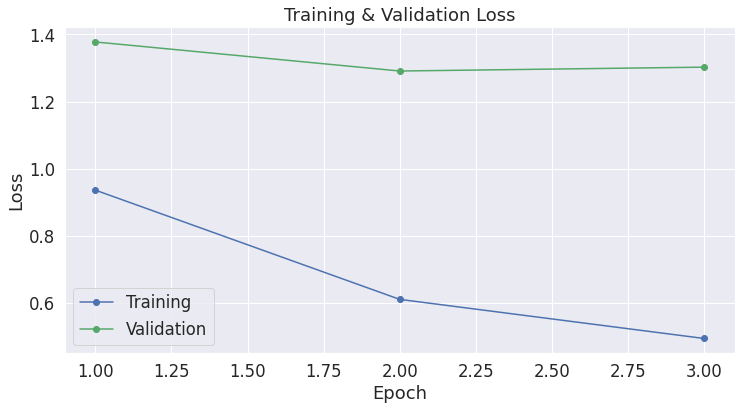

In [51]:
import matplotlib.pyplot as plt
% matplotlib inline

import seaborn as sns

# Use plot styling from seaborn.
sns.set(style='darkgrid')

# Increase the plot size and font size.
sns.set(font_scale=1.5)
plt.rcParams["figure.figsize"] = (12,6)

# Plot the learning curve.
plt.plot(df_stats['Training Loss'], 'b-o', label="Training")
plt.plot(df_stats['Valid. Loss'], 'g-o', label="Validation")

# Label the plot.
plt.title("Training & Validation Loss")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.legend()
plt.show()

## Download the Data

In [52]:
#Download Test Data
used_test_df =pd.DataFrame(test_data)
used_test_df.to_csv(used_test_data_path, encoding='utf-8', index=False)

In [53]:
#Download Encoded Data
encoded_test = pd.DataFrame(encoded_dataset['test'])
encoded_test.to_csv(encoded_test_data_path , encoding='utf-8', index=False)

In [55]:
#Download label2id_df
label2id_df = pd.DataFrame([label2id] )
label2id_df.to_csv(label2id_df_path  , encoding='utf-8', index=False) 